# Bayesian HMM Model

This notebook illustrate how to build and train a Bayesian Hidden Markov Model with the [beer framework](https://github.com/beer-asr/beer).

In [1]:
# Add "beer" to the PYTHONPATH
import sys
sys.path.insert(0, '../')

import copy

import beer
import numpy as np
import torch

# For plotting.
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, gridplot
from bokeh.models import LinearAxis, Range1d
output_notebook()

# Convenience functions for plotting.
import plotting

%load_ext autoreload
%autoreload 2

Loading BokehJS ...

In [2]:
def create_ali_trans_mat(tot_states):
    '''Create align transition matrix for a sequence of units
    Args:
        tot_states (int): length of total number of states of the given
            sequence.
    '''

    trans_mat = torch.diag(torch.ones(tot_states) * .5)
    idx1 = torch.arange(0, tot_states-1, dtype=torch.long)
    idx2 = torch.arange(1, tot_states, dtype=torch.long)
    trans_mat[idx1, idx2] = .5
    trans_mat[-1, -1] = 1.
    return trans_mat

    
# Sequence: AB

seqs = ['A', 'B', 'A']
nsamples = 30
ndim = 2

units = ['A', 'B']
len_seqs = len(seqs)
num_unit_states = 3
tot_states = len(seqs) * num_unit_states

trans_mat = create_ali_trans_mat(tot_states)

means = [np.array([-1.5, 3]), np.array([-1.5, 4]), np.array([-1.5, 5]),
         np.array([1, -3]), np.array([1, -2]), np.array([1, -1])]
covs = [np.array([[.75, -.5], [-.5, 2.]]), np.array([[.75, -.5], [-.5, 2.]]), np.array([[.75, -.5], [-.5, 2.]]),
        np.array([[2, 1], [1, .75]]), np.array([[2, 1], [1, .75]]), np.array([[2, 1], [1, .75]])]

states_id = {'A':[0, 1, 2], 'B':[3, 4, 5]}
dict_seq_state = {}

seqs_id = []
for i, j in enumerate(seqs):
    for u in range(num_unit_states):
        dict_seq_state[num_unit_states * i + u] = states_id[j][u]
        seqs_id.append(states_id[j][u])

normal_sets = list(zip(means,covs))

states = np.zeros(nsamples, dtype=np.int16)
data = np.zeros((nsamples, ndim))
states[0] = states_id['A'][0]
data[0] = np.random.multivariate_normal(means[0], covs[0], size=1)

colors = ['blue', 'blue', 'blue', 'red', 'red', 'red']
fig1 = figure(title='Samples', width=400, height=400)
fig1.circle(data[0, 0], data[0, 1], color=colors[states[0]])


for n in range(1, nsamples):
    states[n] = np.random.choice(np.arange(tot_states), p=trans_mat[states[n-1]].numpy())
    data[n] = np.random.multivariate_normal(means[dict_seq_state[states[n]]], covs[dict_seq_state[states[n]]], size=1)
    fig1.circle(data[n, 0], data[n, 1], color=colors[dict_seq_state[states[n]]], line_width=1)
    fig1.line(data[n-1:n+1, 0], data[n-1:n+1, 1], color='black', line_width=.5, alpha=.5)

states_id = [dict_seq_state[i] for i in states]
    
fig2 = figure(title='Emissions',  width=400, height=400)
colors = ['darkblue', 'blue', 'skyblue', 'darkred','red', 'pink']

for i, n in enumerate(normal_sets):
    plotting.plot_normal(fig2, n[0], n[1], alpha=.3, color=colors[i])
grid = gridplot([[fig1, fig2]])
show(grid)
print(states_id)

[0, 0, 0, 0, 1, 1, 1, 1, 2, 3, 4, 4, 5, 5, 5, 5, 5, 5, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2]


## Model Creation

We create several types of HMMs, each of them has the same transition matrix and initial / final state probability, and a specific type of emission density: 
  * one Normal density per state with full covariance matrix
  * one Normal density per state with diagonal covariance matrix
  * one Normal density per state with full covariance matrix shared across states
  * one Normal density per state with diagonal covariance matrix shared across states.

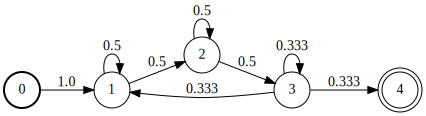

In [3]:
graph = beer.graph.Graph()
s0 = graph.add_state()
s1 = graph.add_state(pdf_id=0)
s2 = graph.add_state(pdf_id=1)
s3 = graph.add_state(pdf_id=2)
s4 = graph.add_state()
graph.start_state = s0
graph.end_state = s4
graph.add_arc(s0, s1)
graph.add_arc(s1, s1)
graph.add_arc(s1, s2)
graph.add_arc(s2, s2)
graph.add_arc(s2, s3)
graph.add_arc(s3, s3)
graph.add_arc(s3, s1)
graph.add_arc(s3, s4)
graph.normalize()
graph

In [4]:
graph.normalize()
loop_graph = graph.compile()

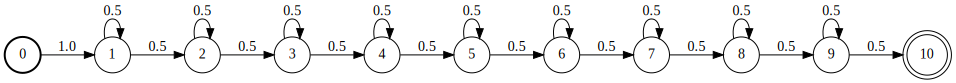

In [5]:
graph = beer.graph.Graph()
s0 = graph.add_state()
s1 = graph.add_state(pdf_id=0)
s2 = graph.add_state(pdf_id=1)
s3 = graph.add_state(pdf_id=2)
s4 = graph.add_state(pdf_id=3)
s5 = graph.add_state(pdf_id=4)
s6 = graph.add_state(pdf_id=5)
s7 = graph.add_state(pdf_id=0)
s8 = graph.add_state(pdf_id=1)
s9 = graph.add_state(pdf_id=2)
s10 = graph.add_state()
graph.start_state = s0
graph.end_state = s10
graph.add_arc(s0, s1)
graph.add_arc(s1, s1)
graph.add_arc(s1, s2)
graph.add_arc(s2, s2)
graph.add_arc(s2, s3)
graph.add_arc(s3, s3)
graph.add_arc(s3, s4)
graph.add_arc(s4, s4)
graph.add_arc(s4, s5)
graph.add_arc(s5, s5)
graph.add_arc(s5, s6)
graph.add_arc(s6, s6)
graph.add_arc(s6, s7)
graph.add_arc(s7, s7)
graph.add_arc(s7, s8)
graph.add_arc(s8, s8)
graph.add_arc(s8, s9)
graph.add_arc(s9, s9)
graph.add_arc(s9, s10)
graph.normalize()
graph

In [6]:
ali_graph = graph.compile().double()

In [7]:
# We use the global mean/cov. matrix of the data to initialize the mixture.
data_mean = torch.from_numpy(data.mean(axis=0)).float()
data_var = torch.from_numpy(np.cov(data.T)).float()

# HMM (diag cov).
modelset = beer.NormalSet.create(data_mean, data_var, size=loop_graph.n_states,
                                prior_strength=1., noise_std=1., 
                                cov_type='diagonal')
hmm_diag_loop = beer.HMM.create(loop_graph, modelset)

modelset = beer.NormalSet.create(data_mean, data_var, size=ali_graph.n_states,
                                prior_strength=1., noise_std=1., 
                                cov_type='diagonal')
hmm_diag_align = beer.HMM.create(ali_graph, modelset)

models = {
    'hmm_diag_loop': hmm_diag_loop.double(),
    'hmm_diag_align': hmm_diag_align.double()
}

## Variational Bayes Training 

In [8]:
epochs = 100
lrate = 1.
X = torch.from_numpy(data).double()

optims = {
    model_name: beer.BayesianModelCoordinateAscentOptimizer(model.mean_field_groups, lrate)
    for model_name, model in models.items()
}

elbos = {
    model_name: []
    for model_name in models
}  

inf_graphs = {
    'hmm_diag_loop': None,
    'hmm_diag_align': ali_graph
}  

for epoch in range(epochs):
    for name, model in models.items():
        optim = optims[name]
        optim.zero_grad()
        elbo = beer.evidence_lower_bound(model, X, datasize=len(X),
                                         inference_graph=inf_graphs[name],
                                         align_type='baum_welch')
        elbo.natural_backward()
        elbos[name].append(float(elbo) / len(X))
        optim.step()


In [9]:
colors = {
    'hmm_diag_loop': 'green',
    'hmm_diag_align': 'blue'
}
# Plot the ELBO.
fig = figure(title='ELBO', width=400, height=400, x_axis_label='step',
              y_axis_label='ln p(X)')
for model_name, elbo in elbos.items():
    fig.line(range(len(elbo)), elbo, legend=model_name, color=colors[model_name])
fig.legend.location = 'bottom_right'

show(fig)

In [10]:
mean = data.mean(axis=0)
var = data.var(axis=0)
std_dev = np.sqrt(max(var))
x_range = (mean[0] - 2 * std_dev, mean[0] + 2 * std_dev)
y_range = (mean[1] - 2 * std_dev, mean[1] + 2 * std_dev)
global_range = (min(x_range[0], y_range[0]), max(x_range[1], y_range[1]))

fig1 = figure(title='HMM (diag) loop', x_range=global_range, y_range=global_range,
              width=400, height=400)
fig1.circle(data[:, 0], data[:, 1], alpha=.5, color='blue')
plotting.plot_hmm(fig1, hmm_diag_loop, alpha=.1, color='blue')

fig2 = figure(title='HMM (diag) align', x_range=global_range, y_range=global_range,
              width=400, height=400)
fig2.circle(data[:, 0], data[:, 1], alpha=.5, color='red')
plotting.plot_hmm(fig2, hmm_diag_align, alpha=.1, color='red')
grid = gridplot([[fig1, fig2]])
show(grid)

### Plotting

In [11]:
# We are mixing bokeh and matplotlib >:-( ! .
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
lhs1 = models['hmm_diag_loop'].align(X, align_type='sample').numpy().T
lhs2 = models['hmm_diag_align'].align(X, align_type='sample').numpy().T

fig1, axarr = plt.subplots(2, 1)
axarr[0].imshow(lhs1, origin='lower')
axarr[0].set_title('HMM loop (diag) lhs')
axarr[1].imshow(lhs2, origin='lower')
axarr[1].set_title('HMM align (diag) lhs')
plt.tight_layout()
plt.show()

AttributeError: 'CompiledGraph' object has no attribute 'sample'